# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

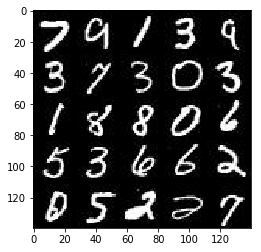

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

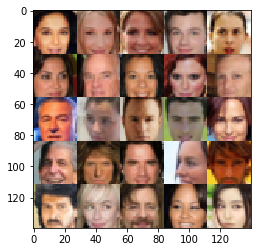

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    learning_rate = tf.placeholder(tf.float32)
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    num_kernels = 32
    kernel_size = 5
    kernel_stride = 2
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # First Convoluational Layer with Leaky ReLu
        # input is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, num_kernels, kernel_size, strides=kernel_stride, padding='SAME')
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second Convoluational Layer with Batch Normalization and Leaky ReLu
        # input 14x14x32
        x2 = tf.layers.conv2d(x1, 2*num_kernels, kernel_size, strides=kernel_stride, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third Convoluational Layer with Batch Normalization and Leaky ReLu
        # input 7x7x64
        x3 = tf.layers.conv2d(x2, 4*num_kernels, kernel_size, strides=kernel_stride, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Flatten and Fully-Connected Output Layers
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    num_kernels = 512
    kernel_size = 3
    kernel_stride = 2
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope("generator", reuse=reuse):
        
        # Reshape input to z dimension input
        x = tf.layers.dense(z, 7 * 7 * num_kernels)
        x = tf.reshape(x, (-1, 7, 7, num_kernels))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        # First Transpose Convolutional Layer
        # input: 7x7x512
        x1 = tf.layers.conv2d_transpose(x, num_kernels//2, kernel_size, strides=kernel_stride, padding='SAME')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
    
        # Second Transpose Convolutional Layer
        # input: 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, num_kernels//2, kernel_size, strides=kernel_stride, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Third Transpose Convolutional Layer
        # input: 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, num_kernels//2, kernel_size, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
    
        # Fourth Convolutional Layer
        # input: 28x28x64
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='SAME')
        out = tf.tanh(logits)
        
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator image
    g_image = generator(input_z, out_channel_dim, is_train=True)

    # Discriminator output on real and fake images
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_image, reuse=True) 
    
    # Discriminator loss on real and fake images
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_out_real)*0.9))

    # Discriminator total loss
    d_loss = d_loss_fake + d_loss_real
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Step counter
                training_step += 1
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Training operations
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input:batch_z, lr:learning_rate})

                if training_step % 100 == 0:
                    
                    # Print Losses
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    
                    # Sample random noise for generator
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                    
                    # Show generator output
                    show_generator_output(sess, 10, z_input, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0309... Generator Loss: 0.3776


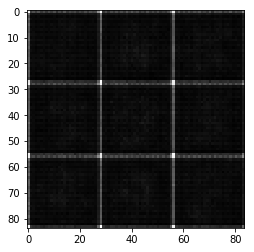

Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.7691


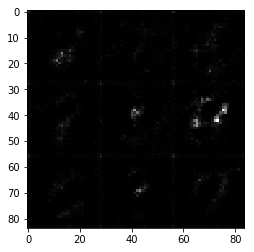

Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.8400


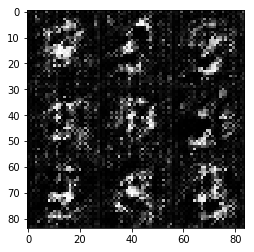

Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 4.0523


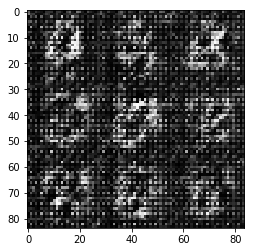

Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 4.9113


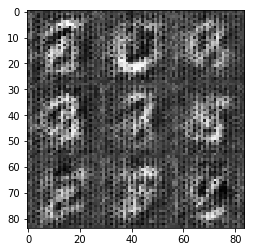

Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.4509


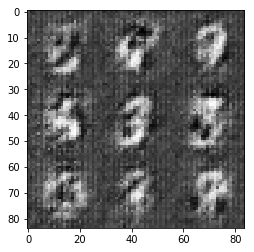

Epoch 1/2... Discriminator Loss: 0.3796... Generator Loss: 3.4553


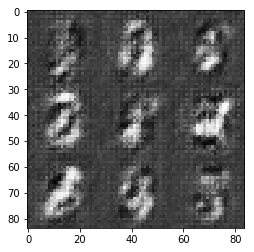

Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.8781


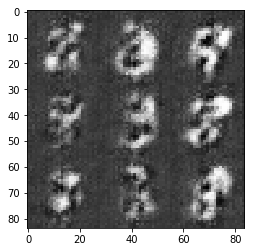

Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 2.7947


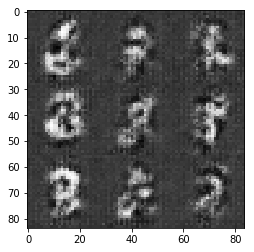

Epoch 1/2... Discriminator Loss: 0.6311... Generator Loss: 1.6205


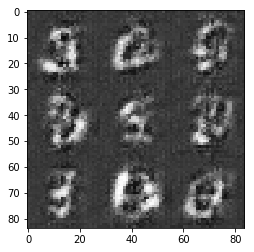

Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.4444


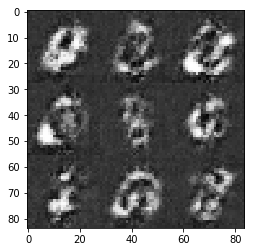

Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 4.1630


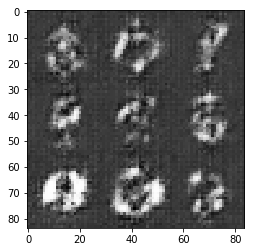

Epoch 1/2... Discriminator Loss: 0.3590... Generator Loss: 5.3065


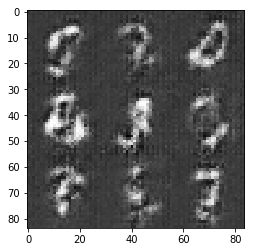

Epoch 1/2... Discriminator Loss: 0.5422... Generator Loss: 1.7967


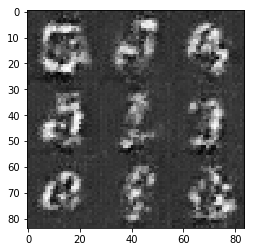

Epoch 1/2... Discriminator Loss: 0.4638... Generator Loss: 2.2169


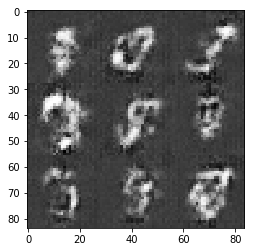

Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 3.5120


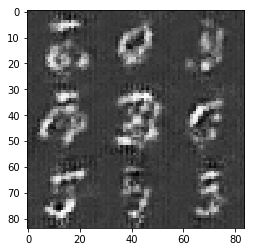

Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 6.8595


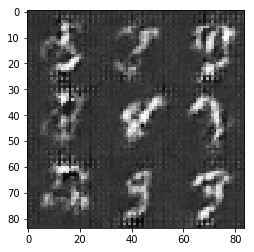

Epoch 1/2... Discriminator Loss: 0.3444... Generator Loss: 5.5823


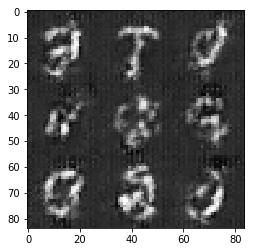

Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 5.0755


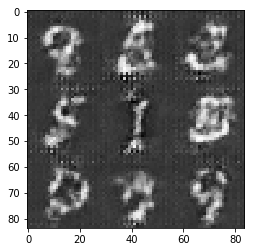

Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.6170


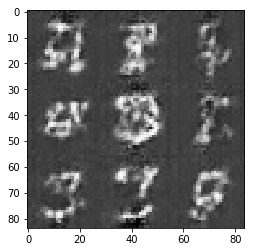

Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 3.5582


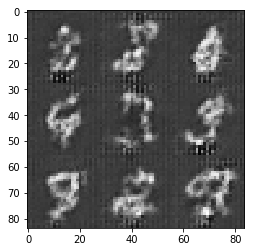

Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 4.6158


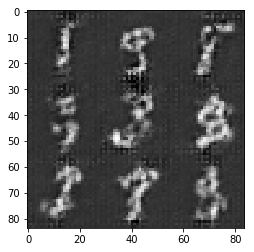

Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 2.6315


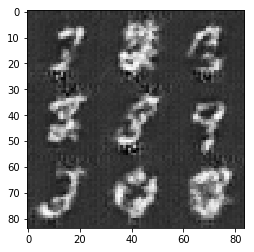

Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 1.5872


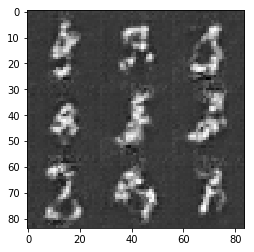

Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 1.6200


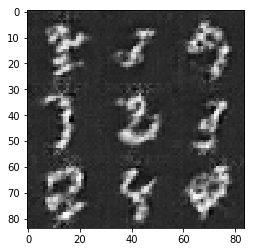

Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 2.0935


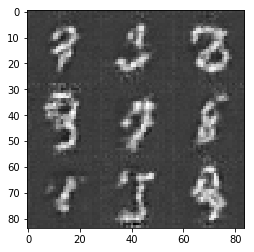

Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.0904


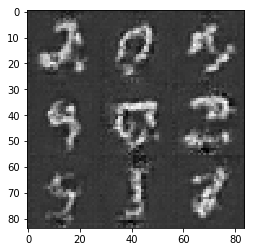

Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.6227


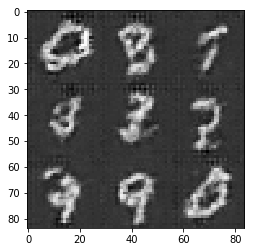

Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.5848


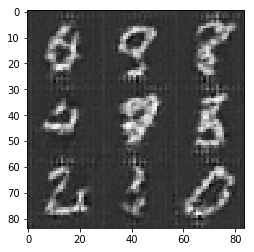

Epoch 1/2... Discriminator Loss: 0.9447... Generator Loss: 1.0466


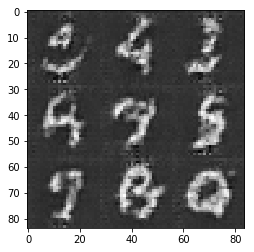

Epoch 1/2... Discriminator Loss: 0.3609... Generator Loss: 7.6662


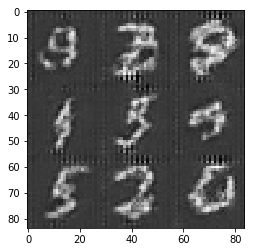

Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 2.2626


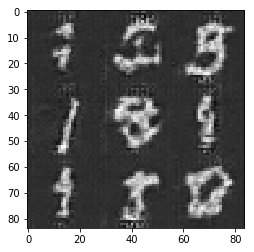

Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 1.6628


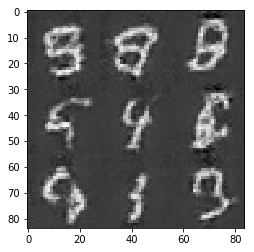

Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.6586


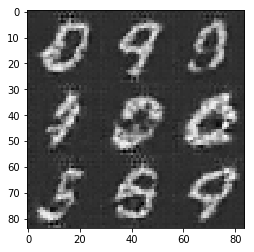

Epoch 1/2... Discriminator Loss: 0.4414... Generator Loss: 2.7763


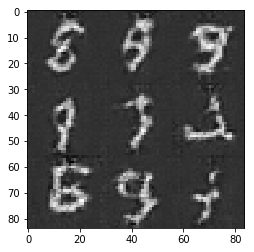

Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.4109


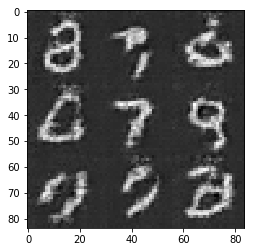

Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.6489


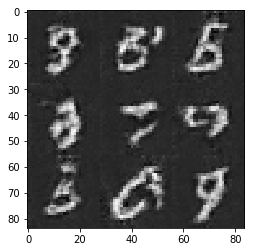

Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 3.3261


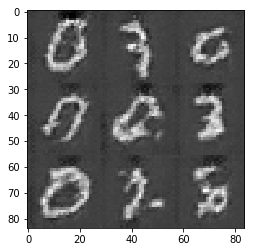

Epoch 1/2... Discriminator Loss: 0.3630... Generator Loss: 4.8844


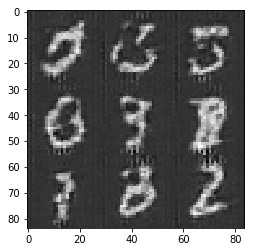

Epoch 1/2... Discriminator Loss: 0.6233... Generator Loss: 1.7718


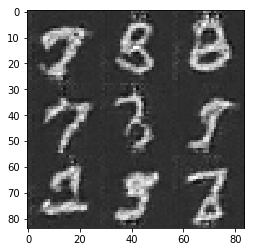

Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 2.0493


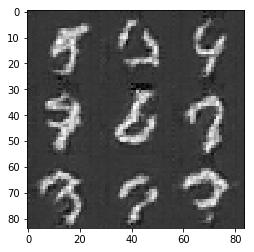

Epoch 1/2... Discriminator Loss: 0.5017... Generator Loss: 3.5604


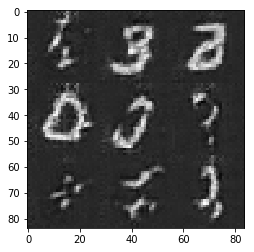

Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 1.9720


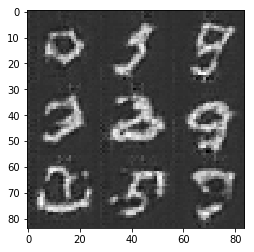

Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 2.2052


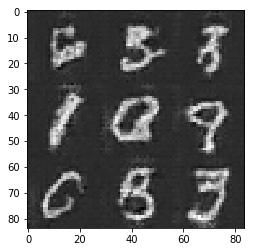

Epoch 1/2... Discriminator Loss: 0.3688... Generator Loss: 4.3153


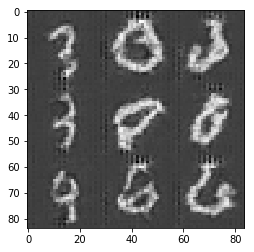

Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 1.5878


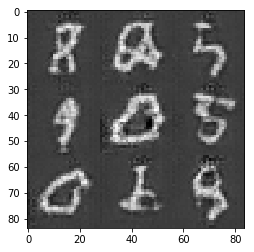

Epoch 1/2... Discriminator Loss: 0.5771... Generator Loss: 2.2612


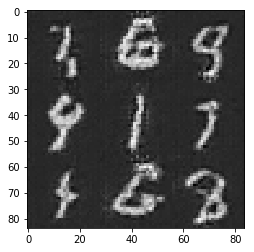

Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 2.4699


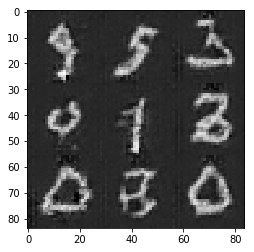

Epoch 1/2... Discriminator Loss: 0.4683... Generator Loss: 2.4148


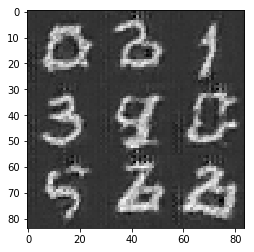

Epoch 1/2... Discriminator Loss: 1.5613... Generator Loss: 0.4047


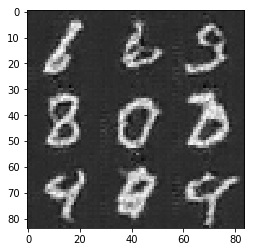

Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.8129


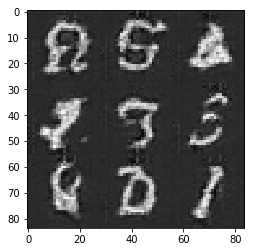

Epoch 1/2... Discriminator Loss: 0.4865... Generator Loss: 2.5271


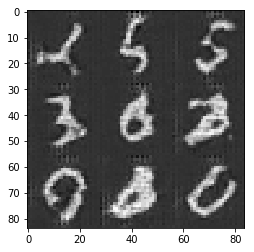

Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 2.5989


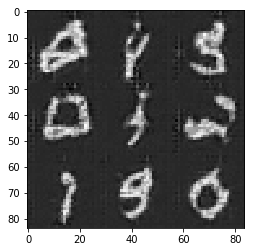

Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 2.7282


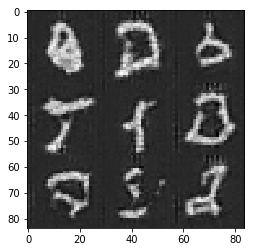

Epoch 1/2... Discriminator Loss: 0.4753... Generator Loss: 2.3158


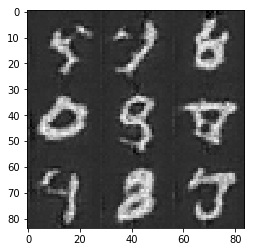

Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.1303


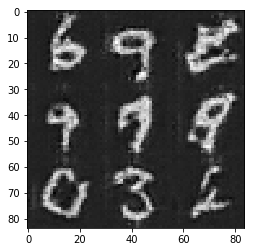

Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 4.5682


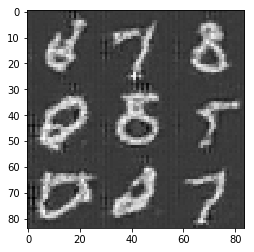

Epoch 1/2... Discriminator Loss: 0.5297... Generator Loss: 3.3788


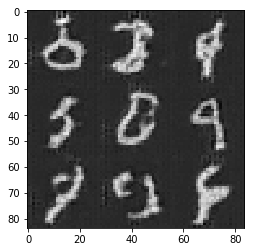

Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 1.9951


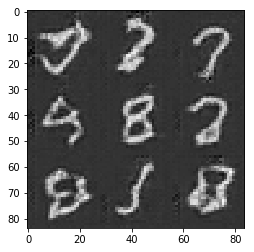

Epoch 1/2... Discriminator Loss: 0.7342... Generator Loss: 1.2530


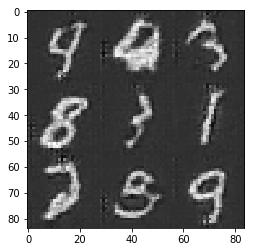

Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.6733


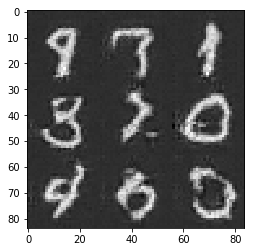

Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 2.0839


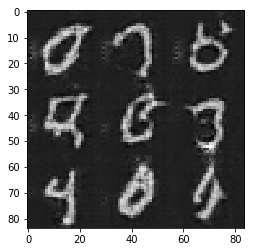

Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.1092


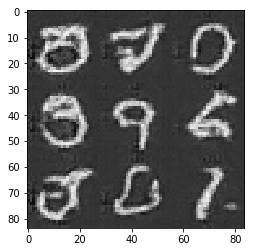

Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.1766


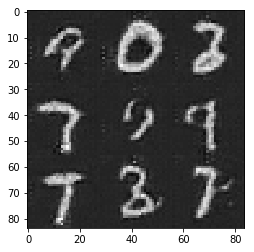

Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.6263


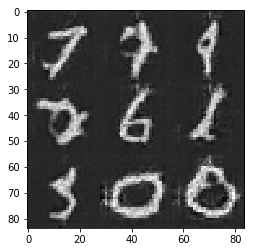

Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 4.7405


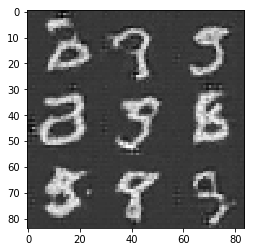

Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 2.1474


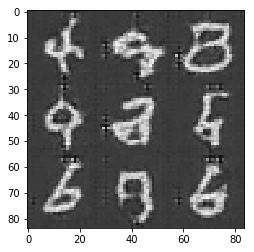

Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.9827


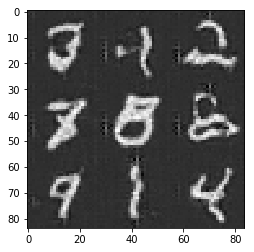

Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 0.9177


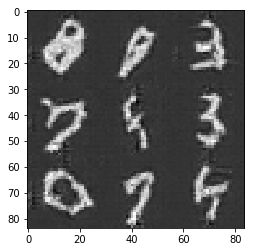

Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.5638


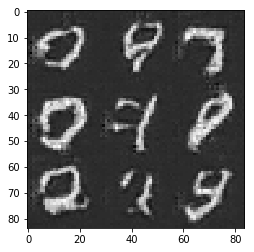

Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.6121


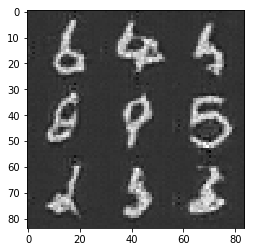

Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 4.2548


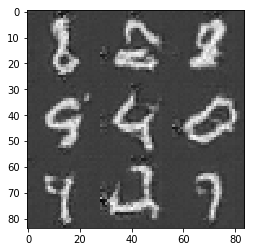

Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 2.0570


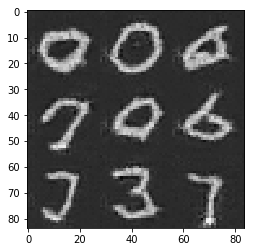

Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 2.3867


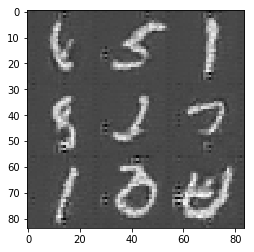

Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 1.6887


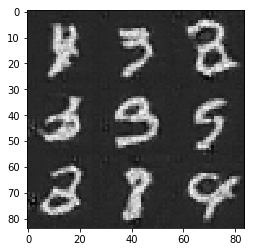

Epoch 2/2... Discriminator Loss: 2.4391... Generator Loss: 0.1464


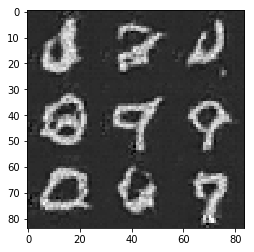

Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 1.0761


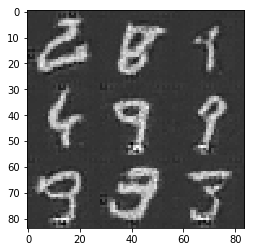

Epoch 2/2... Discriminator Loss: 0.4408... Generator Loss: 2.5038


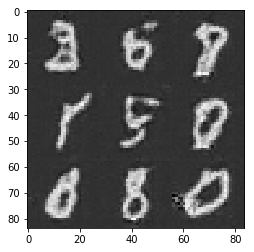

Epoch 2/2... Discriminator Loss: 0.5172... Generator Loss: 1.9485


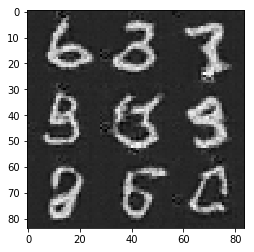

Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.5380


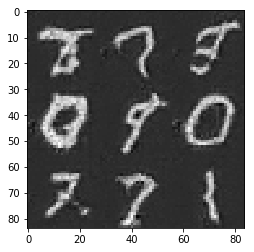

Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.3729


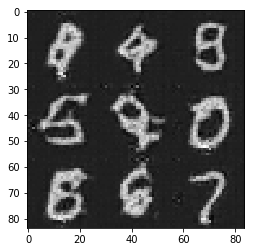

Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.3101


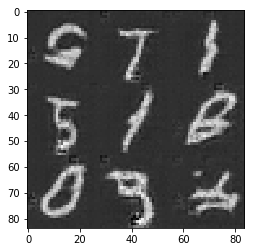

Epoch 2/2... Discriminator Loss: 0.4407... Generator Loss: 2.6400


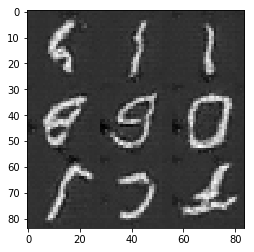

Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 2.0343


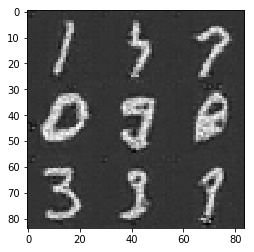

Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.7041


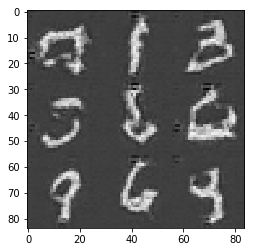

Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.9332


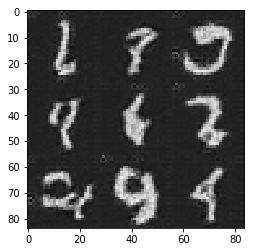

Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 5.5962


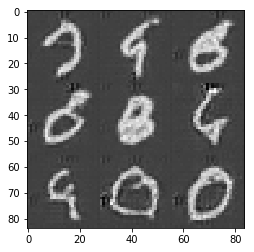

Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.4195


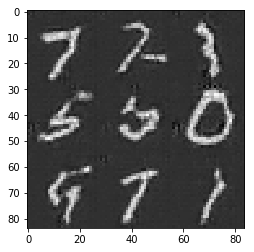

Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 3.0714


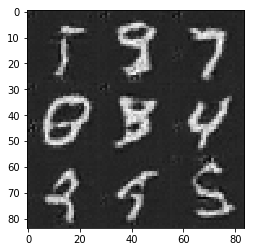

Epoch 2/2... Discriminator Loss: 0.5771... Generator Loss: 1.8954


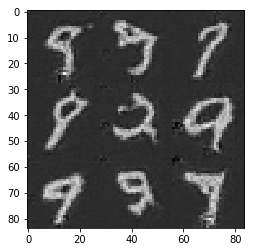

Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 2.5508


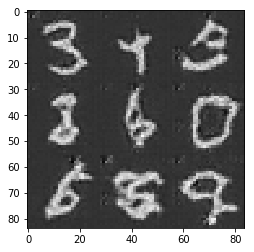

Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.4843


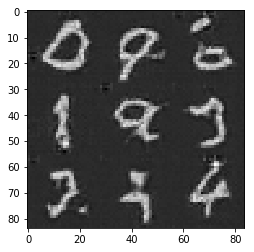

Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.5325


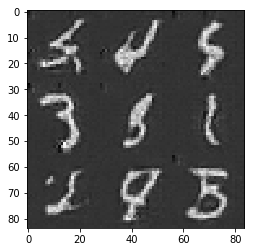

Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 2.9611


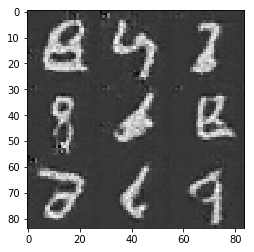

Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 2.2057


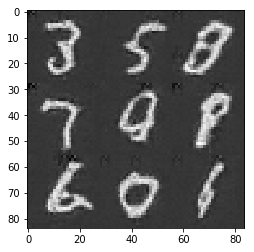

Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 2.8684


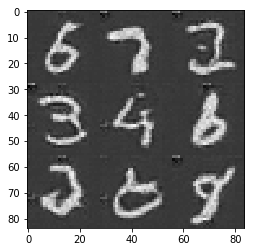

Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.9667


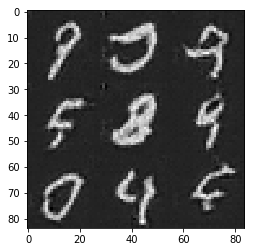

Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.8036


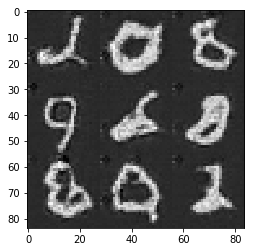

Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 1.9115


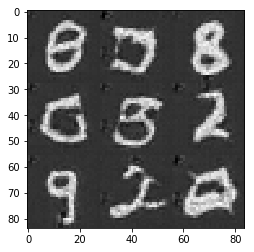

Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 2.9608


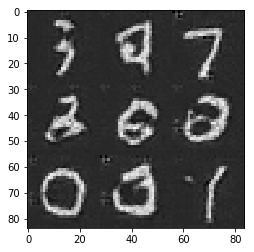

Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.5714


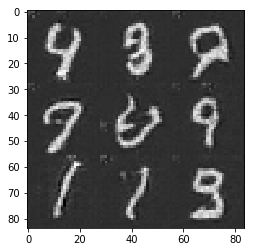

Epoch 2/2... Discriminator Loss: 0.4354... Generator Loss: 2.8978


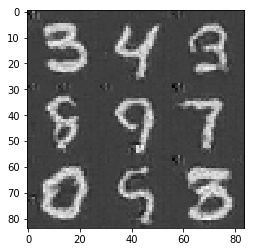

Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.2883


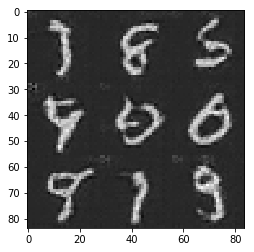

Epoch 2/2... Discriminator Loss: 0.4251... Generator Loss: 3.5749


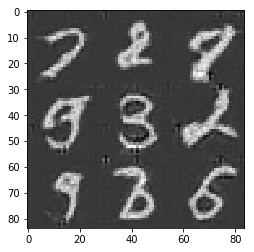

Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.0889


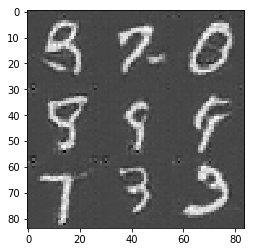

Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.2218


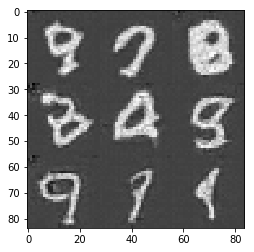

Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 3.5096


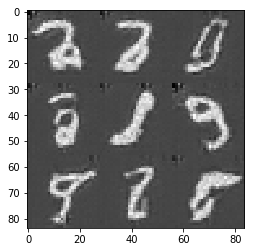

Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 2.0398


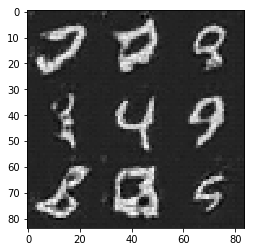

Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 4.6594


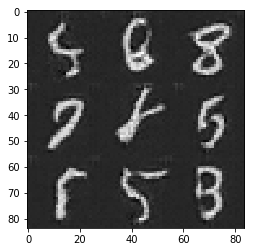

Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.7207


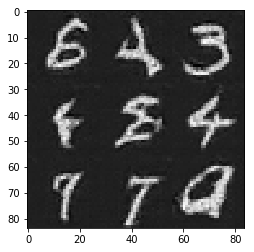

Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.7905


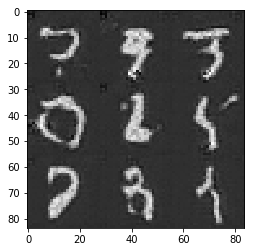

Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 2.9549


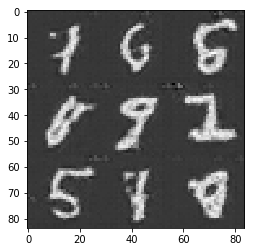

Epoch 2/2... Discriminator Loss: 0.3787... Generator Loss: 4.0620


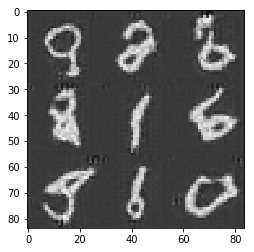

Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.3469


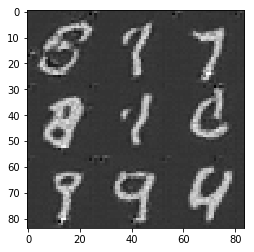

Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 3.2944


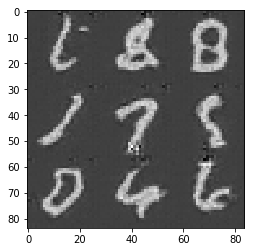

Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 2.1576


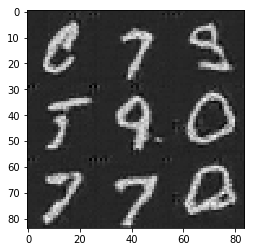

Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 3.8721


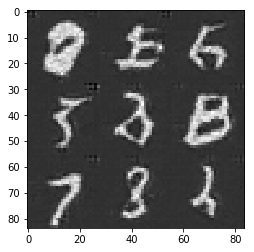

Epoch 2/2... Discriminator Loss: 0.4496... Generator Loss: 3.8917


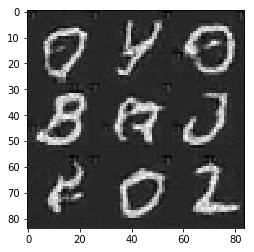

Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.8756


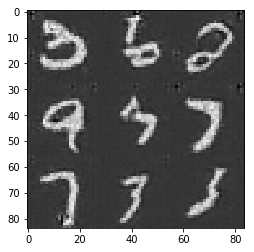

Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 2.6044


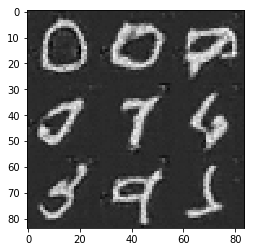

IndexError: list index out of range

In [64]:
batch_size = 10
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.4170


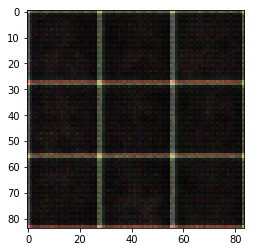

Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.7603


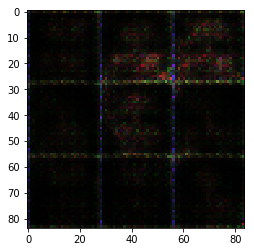

Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.5460


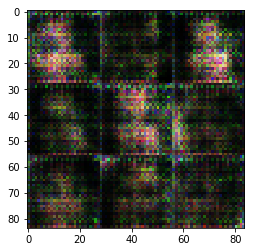

Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.7764


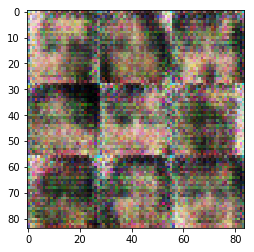

Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 4.6445


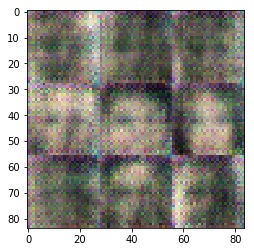

Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 9.0197


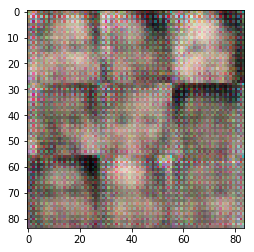

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8648


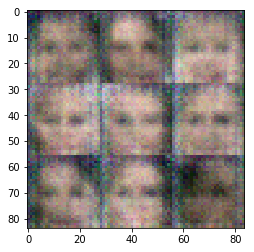

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7798


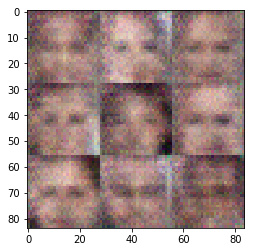

Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8104


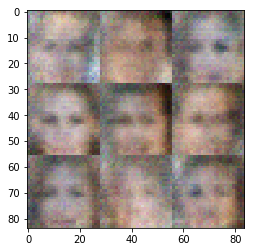

Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7211


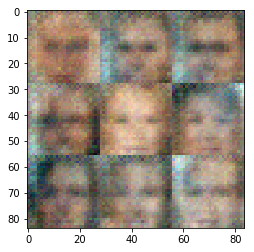

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7257


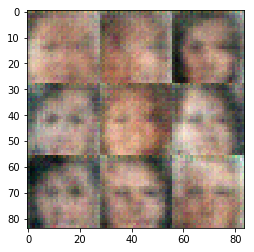

Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.7300


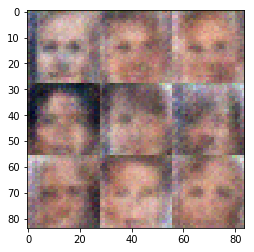

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6873


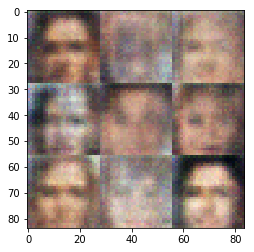

Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.7491


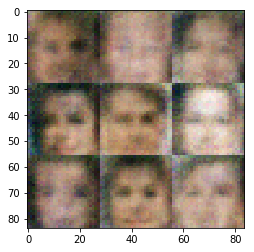

Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.5049


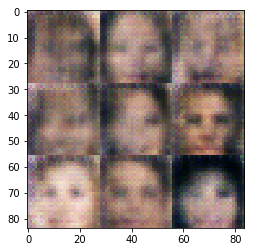

Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.6977


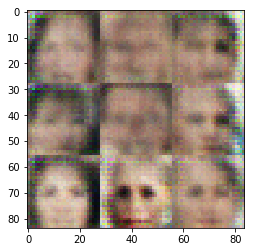

Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 3.3356


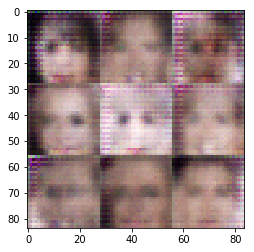

Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 3.3219


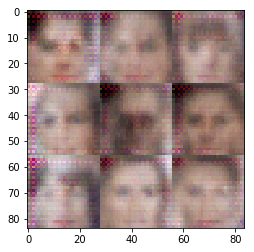

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.2949


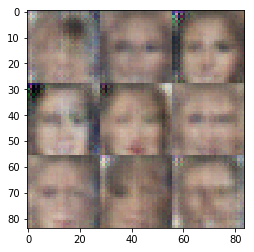

Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.6771


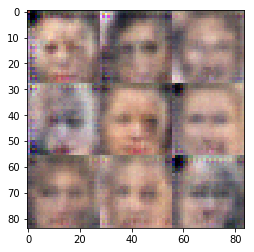

Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 2.3145


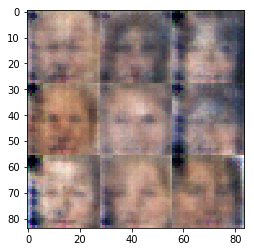

Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 3.9573


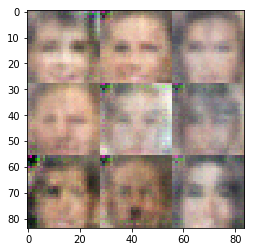

IndexError: list index out of range

In [13]:
batch_size = 10
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.